<a href="https://colab.research.google.com/github/Aswinprakash18/banana-plant-disease-detection-lenet/blob/main/lenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Path to the ZIP file
zip_path = "/content/archive (4).zip"  # Update with your actual file path
extract_path = "/content/data"  # Target directory for extraction

# Check if ZIP file exists
if os.path.exists(zip_path):
    print(f"ZIP file found at: {zip_path}")
    # Ensure target directory exists
    os.makedirs(extract_path, exist_ok=True)

    # Unzip the file and check for errors
    result = os.system(f"unzip -q {zip_path} -d {extract_path}")
    if result == 0:
        print(f"✅ Dataset successfully extracted to: {extract_path}")
    else:
        print(f"❌ Failed to extract dataset. Error code: {result}")
else:
    print(f"❌ ZIP file not found at: {zip_path}")


❌ ZIP file not found at: /content/archive (4).zip


In [ ]:
import zipfile

zip_path = "/content/archive (4).zip"
extract_path = "/content/data"

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"✅ Dataset successfully extracted to: {extract_path}")
except zipfile.BadZipFile:
    print("❌ The ZIP file is corrupted or invalid.")
except Exception as e:
    print(f"❌ An error occurred: {e}")


❌ An error occurred: [Errno 2] No such file or directory: '/content/archive (4).zip'


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array, load_img
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import sobel
from skimage.filters import scharr

In [ ]:
data_dir = '/kaggle/input/banana-disease-recognition-dataset/Banana Disease Recognition Dataset/Augmented images/Augmented images'
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
train_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(data_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', subset='validation')

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
class_weights

In [ ]:
images, labels = next(train_generator)

def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_images(images, labels)

In [ ]:
def apply_sobel(images_arr):
    sobel_images = []
    for img in images_arr:
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
        sobel_x = sobel(gray_img, axis=0, mode='constant')
        sobel_y = sobel(gray_img, axis=1, mode='constant')
        sobel_img = np.hypot(sobel_x, sobel_y)
        sobel_images.append(sobel_img)
    return np.array(sobel_images)

sobel_images = apply_sobel(images)

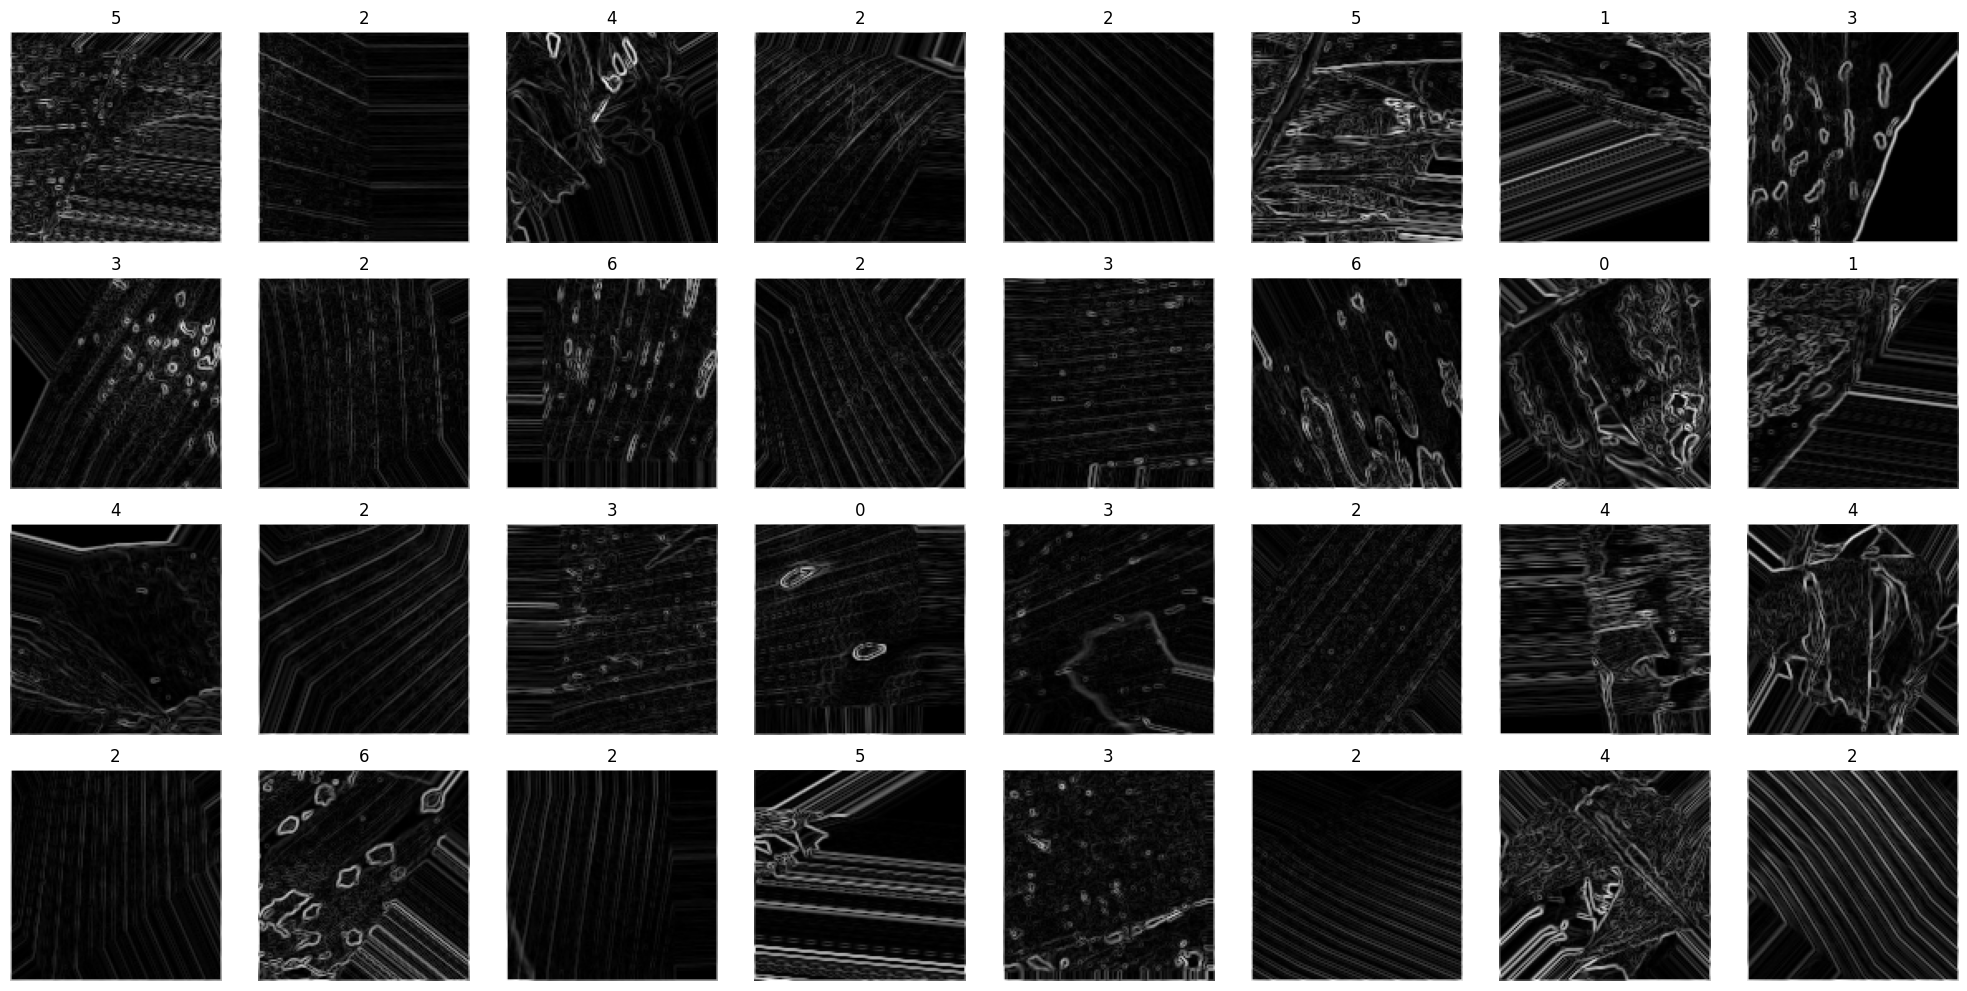

In [ ]:
def plot_sobel_images(original_images, sobel_images, labels_arr):
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    for orig_img, sob_img, lbl, ax in zip(original_images, sobel_images, labels_arr, axes):
        ax.imshow(sob_img, cmap='gray')
        ax.axis('off')
        ax.set_title(np.argmax(lbl))
    plt.tight_layout()
    plt.show()

plot_sobel_images(images, sobel_images, labels)

In [ ]:
type(train_generator)

keras.src.legacy.preprocessing.image.DirectoryIterator

In [ ]:
model_lenet = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

In [ ]:
model_lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_lenet.summary()

In [ ]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

In [ ]:
base_model_resnet.trainable = False
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model_resnet.summary()